In [19]:
# import kagglehub
import os
# # Download latest version
# path = os.path.join(os.getcwd(),"data") 
# path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction",output_dir= path)

# print("Path to dataset files:", path)

In [20]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
from skimage.filters import threshold_niblack, threshold_sauvola
from torchvision import transforms

In [21]:
# Image Transform Pipeline using torchvision.transforms
class BGRtoGrayscaleNormalize:
    """Convert BGR to Grayscale and Normalize to [0, 1]"""
    def __call__(self, image):
        # Convert BGR to RGB first, then to Grayscale
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        # Normalize to [0, 1]
        gray = gray.astype(np.float32) / 255.0
        return gray

# Create transform pipeline
transform = transforms.Compose([
    BGRtoGrayscaleNormalize()
])


# DataLoader for DRIVE Dataset
class DRIVEDataLoader:
    """
    DRIVE Dataset Loader - loads retinal images and vessel segmentations
    
    Returns:
    - 'image': Preprocessed grayscale image (normalized to [0, 1])
    - 'vessels': Vessel segmentation masked by FOV (binary)
    - 'name': Image identifier
    """
    def __init__(self, data_dir: str, split: str = 'training', transforms=None):
        self.split_dir = Path(data_dir) / 'DRIVE' / split
        self.image_dir = self.split_dir / 'images'
        self.mask_dir = self.split_dir / 'mask'
        self.split = split
        self.transforms = transforms
        
        # Vessel directory only for training
        if split == 'training':
            self.vessel_dir = self.split_dir / '1st_manual'
        else:
            self.vessel_dir = None
        
        # Get image names
        self.image_names = sorted([f.stem for f in self.image_dir.glob('*.tif')])
        print(f"Loaded {len(self.image_names)} images from {split} set")
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        name = self.image_names[idx]
        
        # Load image
        img_path = self.image_dir / f"{name}.tif"
        image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
        # Load FOV mask
        mask_path = self.mask_dir / f"{name}_mask.gif"
        fov_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        fov_mask = (fov_mask > 0).astype(np.uint8)
        
        # Load and mask vessels
        if self.vessel_dir:
            img_number = name.split('_')[0]
            vessel_path = self.vessel_dir / f"{img_number}_manual1.gif"
            vessels = cv2.imread(str(vessel_path), cv2.IMREAD_GRAYSCALE)
            vessels = (vessels > 0).astype(np.uint8)
            vessels = vessels * fov_mask  # Apply FOV mask
        else:
            vessels = None
        
        return {
            'image': image,
            'vessels': vessels,
            'name': name
        }


# Initialize dataloaders
data_path = os.path.join(os.getcwd(), "data")
train_loader = DRIVEDataLoader(data_path, split='training', transforms=transform)
test_loader = DRIVEDataLoader(data_path, split='test', transforms=transform)

Loaded 20 images from training set
Loaded 20 images from test set


In [22]:
# Segmentation Methods: Niblack vs Sauvola

def apply_niblack(image: np.ndarray, window_size: int = 25, k: float = -0.2) -> np.ndarray:
    """Niblack Local Thresholding - detects dark pixels (vessels)"""
    # Ensure image is in range [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Apply Niblack thresholding
    threshold = threshold_niblack(image, window_size=window_size, k=k)
    # Use <= threshold to detect DARK pixels (vessels)
    binary = (image <= threshold).astype(np.uint8) * 255
    return binary

def apply_sauvola(image: np.ndarray, window_size: int = 25, k: float = 0.2) -> np.ndarray:
    """Sauvola Local Thresholding - detects dark pixels (vessels)"""
    # Ensure image is in range [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Apply Sauvola thresholding
    threshold = threshold_sauvola(image, window_size=window_size, k=k)
    # Use <= threshold to detect DARK pixels (vessels)
    binary = (image <= threshold).astype(np.uint8) * 255
    return binary

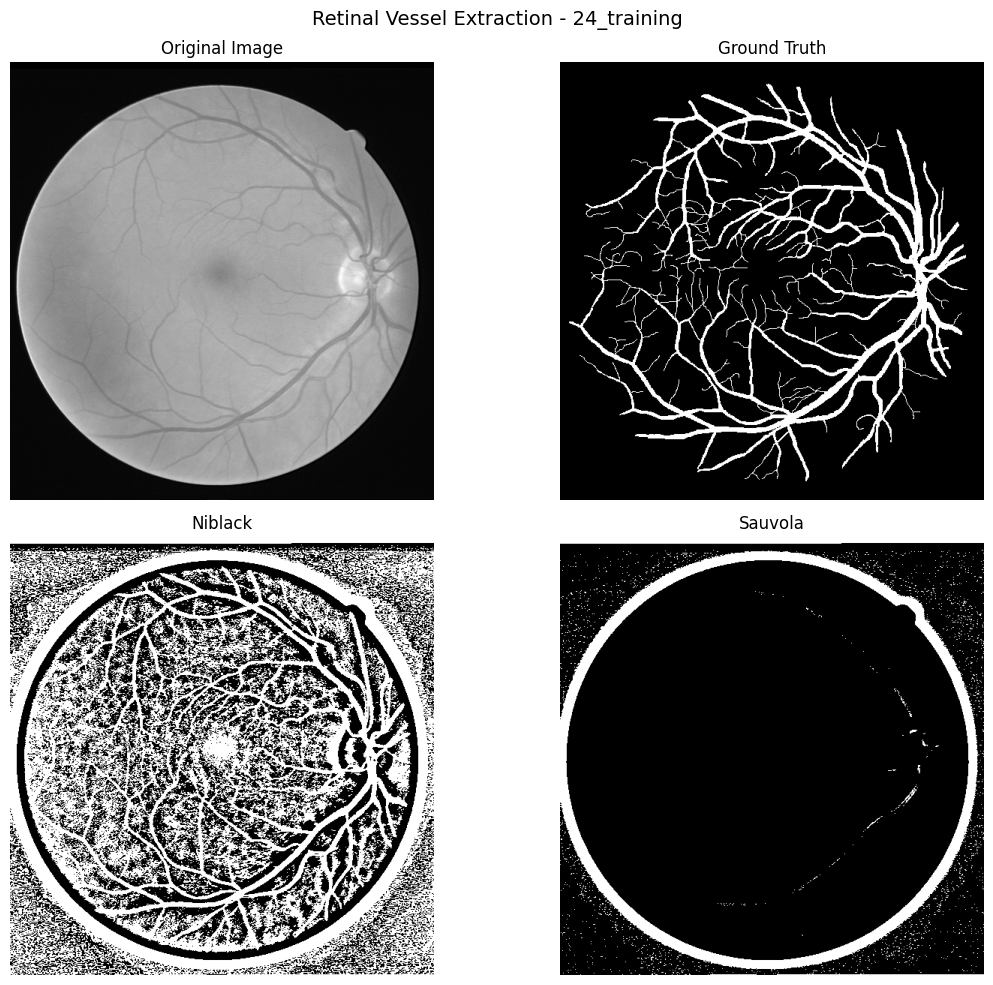

In [23]:
# Visualization: Random Image with Both Methods

sample_idx = random.randint(0, len(train_loader) - 1)
sample = train_loader[sample_idx]

image = sample['image']
vessels_gt = sample['vessels']
image_name = sample['name']

niblack_result = apply_niblack(image, window_size=25, k=-0.2)
sauvola_result = apply_sauvola(image, window_size=25, k=0.2)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Retinal Vessel Extraction - {image_name}', fontsize=14)

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(vessels_gt, cmap='gray')
axes[0, 1].set_title('Ground Truth')
axes[0, 1].axis('off')

axes[1, 0].imshow(niblack_result, cmap='gray')
axes[1, 0].set_title('Niblack')
axes[1, 0].axis('off')

axes[1, 1].imshow(sauvola_result, cmap='gray')
axes[1, 1].set_title('Sauvola')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
def sensitivity(pred: np.ndarray, gt: np.ndarray) -> float:
    """Sensitivity (Recall) - True positive rate"""
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    tp = np.sum((pred_bin == 1) & (gt_bin == 1))
    fn = np.sum((pred_bin == 0) & (gt_bin == 1))
    total_actual_positives = tp + fn
    if total_actual_positives == 0:
        return 0.0
    return float(tp) / float(total_actual_positives)

def dice_coefficient(pred: np.ndarray, gt: np.ndarray) -> float:
    """Dice Similarity Coefficient (F1 Score)"""
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    tp = np.sum((pred_bin == 1) & (gt_bin == 1))
    fp = np.sum((pred_bin == 1) & (gt_bin == 0))
    fn = np.sum((pred_bin == 0) & (gt_bin == 1))
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    return float(dice)

def jaccard_index(pred: np.ndarray, gt: np.ndarray) -> float:
    """Jaccard Index (Intersection over Union)"""
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    intersection = np.sum((pred_bin == 1) & (gt_bin == 1))
    union = np.sum((pred_bin == 1) | (gt_bin == 1))
    if union == 0:
        return 0.0
    return float(intersection) / float(union)

# Calculate metrics across all training images
niblack_sensitivity = []
niblack_dice = []
niblack_jaccard = []

sauvola_sensitivity = []
sauvola_dice = []
sauvola_jaccard = []

print("Computing metrics...")
for idx in range(len(train_loader)):
    sample = train_loader[idx]
    image = sample['image']
    vessels_gt = sample['vessels']
    
    # Apply thresholding methods
    niblack_pred = apply_niblack(image, window_size=25, k=-0.2)
    sauvola_pred = apply_sauvola(image, window_size=25, k=0.2)
    
    # Compute Niblack metrics
    niblack_sensitivity.append(sensitivity(niblack_pred, vessels_gt))
    niblack_dice.append(dice_coefficient(niblack_pred, vessels_gt))
    niblack_jaccard.append(jaccard_index(niblack_pred, vessels_gt))
    
    # Compute Sauvola metrics
    sauvola_sensitivity.append(sensitivity(sauvola_pred, vessels_gt))
    sauvola_dice.append(dice_coefficient(sauvola_pred, vessels_gt))
    sauvola_jaccard.append(jaccard_index(sauvola_pred, vessels_gt))

print("\nNiblack:")
print(f"Sensitivity: {np.mean(niblack_sensitivity):.4f}")
print(f"Dice: {np.mean(niblack_dice):.4f}")
print(f"Jaccard: {np.mean(niblack_jaccard):.4f}")

print("\nSauvola:")
print(f"Sensitivity: {np.mean(sauvola_sensitivity):.4f}")
print(f"Dice: {np.mean(sauvola_dice):.4f}")
print(f"Jaccard: {np.mean(sauvola_jaccard):.4f}")

Computing metrics...

Niblack:
Sensitivity: 0.8936
Dice: 0.2341
Jaccard: 0.1329

Sauvola:
Sensitivity: 0.0550
Dice: 0.0517
Jaccard: 0.0269
